In [1]:
# Gym stuff
import gymnasium as gym
import torch
import os
import sys
sys.path.append(os.path.abspath("..")) 
import gym_envs

# Stable baselines - rl stuff
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import seaborn as sns
import os

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV21Environment-v0', 'GymV26Environment-v0', 'forex-v0', 'stocks-v0', 'custom-stocks-v0'])


In [2]:
apple_df = pd.read_csv('../data/appldata.csv', parse_dates=["Date"], index_col="Date")
gamestop_df = pd.read_csv('../data/gmedata.csv', parse_dates=["Date"], index_col="Date")
df = apple_df
dfs = {
    "AAPL": apple_df,  # Apple stock data
    "GME": gamestop_df,  # Gamestop stock data
}
dfs

{'AAPL':              Close    Open    High     Low     Vol. Change %
 Date                                                        
 2024-03-27  173.31  170.30  173.58  170.14   59.11M    2.12%
 2024-03-26  169.71  170.01  171.41  169.65   57.22M   -0.67%
 2024-03-25  170.85  170.37  171.94  169.46   54.21M   -0.83%
 2024-03-22  172.28  171.76  173.05  170.06   71.16M    0.53%
 2024-03-21  171.37  177.05  177.49  170.84  106.18M   -4.09%
 ...            ...     ...     ...     ...      ...      ...
 1980-12-18    0.12    0.12    0.12    0.12   73.45M    0.00%
 1980-12-17    0.12    0.12    0.12    0.12   86.44M    9.09%
 1980-12-16    0.11    0.11    0.11    0.11  105.73M   -8.33%
 1980-12-15    0.12    0.12    0.12    0.12  175.88M   -7.69%
 1980-12-12    0.13    0.13    0.13    0.13  469.03M  -99.88%
 
 [10912 rows x 6 columns],
 'GME':               Open    High     Low   Close      Volume
 Date                                                  
 2021-03-12  275.00  295.50  262.27  2

In [4]:
# Create the environment setup by gym_anytrading
env = gym.make('custom-stocks-v0', trade_fee_percent=0.001, window_size=10, frame_bound=(10, 100), render_mode=None)
# It is to be noted that the first element of frame_bound should be greater than or equal to window_size.

In [5]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> Action space:", env.unwrapped.action_space)
print("> Observation space:", env.unwrapped.observation_space)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env information:
> shape: (10, 2)
> Action space: Discrete(2)
> Observation space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)
> df.shape: (10912, 6)
> prices.shape: (100,)
> signal_features.shape: (100, 2)
> max_possible_profit: 1.4882555755123956


In [ ]:
# Print Stats
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):
    def __init__(self, check_freq: int = 100, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.progress_bar = None

    def _on_training_start(self) -> None:
        """
        Called at the start of training.
        Initializes the progress bar.
        """
        if self.verbose:
            self.progress_bar = tqdm(total=self.model._total_timesteps, desc="Training Progress")

    def _on_step(self) -> bool:
        """
        Updates the progress bar on each step.
        """
        if self.progress_bar is not None:
            self.progress_bar.update(1)
        return True

    def _on_training_end(self) -> None:
        """
        Closes the progress bar at the end of training.
        """
        if self.progress_bar is not None:
            self.progress_bar.close()


class RewardTrackerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_count = 0
        self.total_reward = 0

    def _on_step(self) -> bool:
        # Get rewards from the environment
        rewards = self.locals['rewards']
        self.total_reward += np.sum(rewards)

        # Check if an episode is done
        dones = self.locals['dones']
        for done in dones:
            if done:
                self.episode_rewards.append(self.total_reward)
                self.episode_lengths.append(self.episode_count)
                self.total_reward = 0
                self.episode_count += 1
        
        return True

In [ ]:
# Train + Test the environment

seed = 42  # random seed
total_num_episodes = 50

print ("seed :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

#learning_timesteps_list_in_K = [25]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

progress_callback = ProgressBarCallback(check_freq=100)
reward_callback = RewardTrackerCallback()

# Train vectorized environment
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)
env = DummyVecEnv([env_maker])

model = PPO('MlpPolicy', env, verbose=0) 
#model.learn(total_timesteps=10000, callback=ProgressBarCallback(100))
model.learn(total_timesteps=10000, callback=[progress_callback, reward_callback])

# Define the directory to save the model
save_dir = "../models/"
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

# Find the next version number
version = 1
while os.path.exists(f"{save_dir}model_v{version}"):
    version += 1

# Save the model with the new version number
model.save(f"{save_dir}model_v{version}")

seed : 42


In [9]:
# Plot training rewards
plt.figure(figsize=(10, 5))
plt.plot(reward_callback.episode_lengths, reward_callback.episode_rewards, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance (Reward vs Episodes)")
plt.grid()
plt.show()

NameError: name 'reward_callback' is not defined

<Figure size 1000x500 with 0 Axes>

info: {'total_reward': 436.23001289367676, 'total_profit': 11.123120775187697, 'position': <Positions.Short: 0>}
Total reward: 436.23001289367676


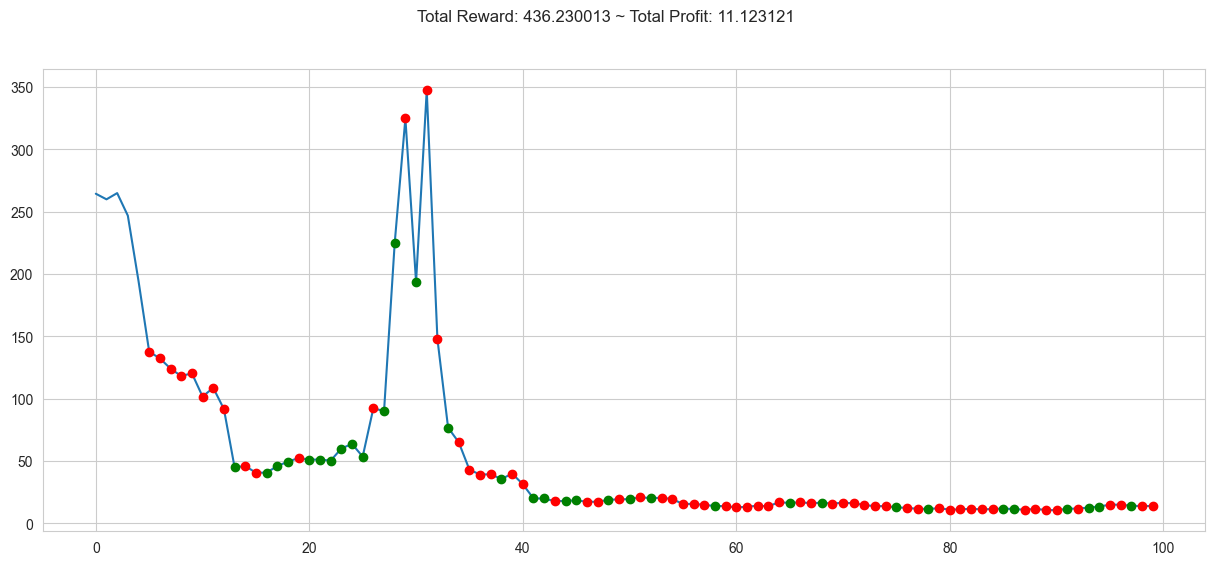

In [ ]:
# Initialize the environment
env = gym.make('stocks-v0', df=df, frame_bound=(5, 100), window_size=5)
model = PPO.load("../models/model_v1")  # Change to your saved model path

# Test the model
observation, info = env.reset()  # Reset the environment

done = False
total_reward = 0

while not done:
    action, _states = model.predict(observation)  # Get action from the model
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward  # Accumulate the reward
    done = terminated or truncated  # Check if episode is done
    
    if done:
        print("info:", info)  # Output additional information when done
        break


print(f"Total reward: {total_reward}")
# Plot the results
plt.figure(figsize=(15, 6))
plt.cla()
# Ensure this method is correctly defined in your environment
env.unwrapped.render_all()  
plt.show()